In [2]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, log_loss, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

In [10]:
df=pd.read_csv("datasets_cleaned_balanced.csv")

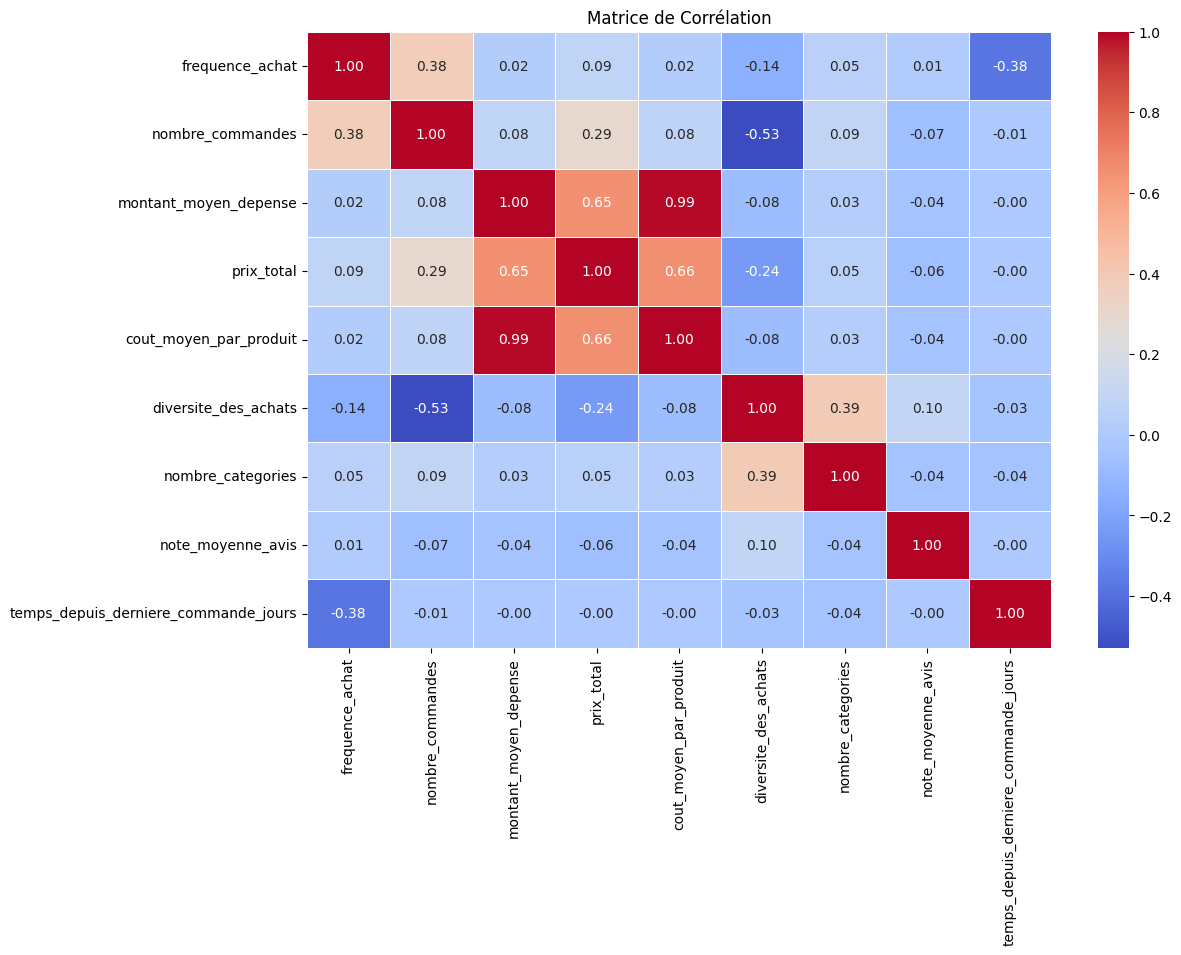

In [14]:
features = ['frequence_achat','nombre_commandes','montant_moyen_depense',
            'prix_total','cout_moyen_par_produit','diversite_des_achats',
            'nombre_categories','note_moyenne_avis','temps_depuis_derniere_commande_jours'
            
            ]

# Matrice de corrélation
plt.figure(figsize=(12, 8))
sns.heatmap(df[features].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matrice de Corrélation")
plt.show()

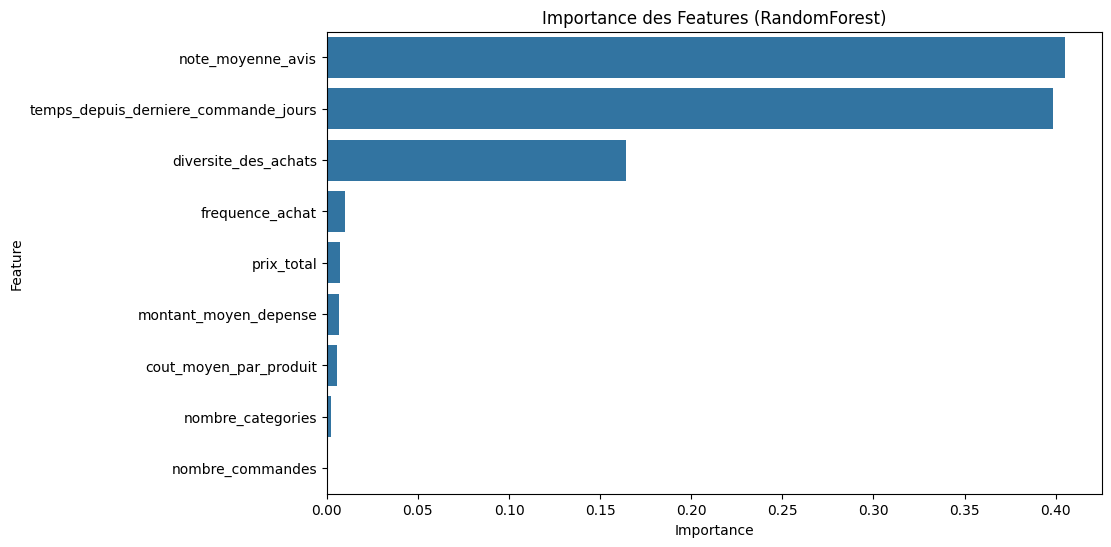

In [15]:
feature = ['frequence_achat','nombre_commandes','montant_moyen_depense',
            'prix_total','cout_moyen_par_produit','diversite_des_achats',
            'nombre_categories','note_moyenne_avis','temps_depuis_derniere_commande_jours',
            
            ]
X=df[feature]
y=df['segment_client']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
# Importance des features
importances = model.feature_importances_
feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": importances})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# Affichage
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance)
plt.title("Importance des Features (RandomForest)")
plt.show()


In [17]:
import numpy as np
df=pd.read_csv("datasets_cleaned_balanced.csv")

# Correction des valeurs absolues
df["retard_livraison_jours"] = df["retard_livraison_jours"].abs()

# Définition des features et de la cible

features = ['frequence_achat','nombre_commandes','montant_moyen_depense',
            'prix_total','diversite_des_achats',
            'nombre_categories','note_moyenne_avis','temps_depuis_derniere_commande_jours'
            
            ]
target = 'segment_client'  
X = df[features]
y = df[target]

# Transformation log1p des variables asymétriques
cols_to_log = ['frequence_achat','nombre_commandes','montant_moyen_depense',
            'prix_total','diversite_des_achats',
            'nombre_categories','note_moyenne_avis','temps_depuis_derniere_commande_jours'
            
            ]
for col in cols_to_log:
    X[col] = np.log1p(X[col])

# Standardisation des variables
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=features)

# Séparation des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Définition des modèles et hyperparamètres
models = {
    "RandomForest": {
        "model": RandomForestClassifier(),
        "params": {"n_estimators": [50, 100, 200], "max_depth": [5, 10, 20]}
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss"),
        "params": {"n_estimators": [50, 100, 200], "max_depth": [3, 6, 10], "learning_rate": [0.01, 0.1, 0.2]}
    },
    "LightGBM": {
        "model": LGBMClassifier(),
        "params": {"n_estimators": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2]}
    },
    "CatBoost": {
        "model": CatBoostClassifier(verbose=0),
        "params": {"iterations": [50, 100, 200], "learning_rate": [0.01, 0.1, 0.2]}
    },
    "MLP": {
        "model": MLPClassifier(max_iter=500),
        "params": {"hidden_layer_sizes": [(50,), (100,), (50,50)], "alpha": [0.0001, 0.001, 0.01]}
    },
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=500, solver='liblinear', multi_class='ovr'),
        "params": {"C": [0.01, 0.1, 1, 10]}
    },
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {"n_neighbors": [3, 5, 7, 10]}
    },
    "DecisionTree": {
        "model": DecisionTreeClassifier(),
        "params": {"max_depth": [3, 5, 10, 20]}
    }
}

# Entraînement et évaluation
best_model = None
best_accuracy = 0
best_model_name = ""
results = []

for name, m in models.items():
    print(f"🔍 Entraînement de {name}...")

    grid = GridSearchCV(m["model"], m["params"], scoring="accuracy", cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    
    # Prédictions
    y_pred = grid.best_estimator_.predict(X_test)
    y_proba = grid.best_estimator_.predict_proba(X_test)
    
    # Évaluation
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    loss = log_loss(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)
    
    # Stocker les résultats
    results.append({
        "Modèle": name,
        "Meilleurs Paramètres": grid.best_params_,
        "Accuracy": round(accuracy, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1-Score": round(f1, 4),
        "Log-Loss": round(loss, 4),
        "Matrice Confusion": cm.tolist()
    })
    
    print(f"✅ {name} - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, Log-Loss: {loss:.4f}")

    # Sélection du meilleur modèle
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = grid.best_estimator_
        best_model_name = name

# Création d'un DataFrame des résultats
df_results = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)

# Affichage des performances
print("\n📊 Tableau des résultats :")
print(df_results)

# Sauvegarde du meilleur modèle
print(f"\n🎯 Meilleur modèle : {best_model_name}")


C:\Users\ahmad\AppData\Local\Temp\ipykernel_7908\1486666225.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = np.log1p(X[col])


🔍 Entraînement de RandomForest...
✅ RandomForest - Accuracy: 0.9874, Precision: 0.9874, Recall: 0.9874, F1-Score: 0.9874, Log-Loss: 0.0431
🔍 Entraînement de XGBoost...


c:\Users\ahmad\Desktop\PFE\env\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:32:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ XGBoost - Accuracy: 0.9886, Precision: 0.9886, Recall: 0.9886, F1-Score: 0.9886, Log-Loss: 0.0340
🔍 Entraînement de LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1083
[LightGBM] [Info] Number of data points in the train set: 75518, number of used features: 8
[LightGBM] [Info] Start training from score -1.098599
[LightGBM] [Info] Start training from score -1.098599
[LightGBM] [Info] Start training from score -1.098639
✅ LightGBM - Accuracy: 0.9880, Precision: 0.9881, Recall: 0.9880, F1-Score: 0.9880, Log-Loss: 0.0326
🔍 Entraînement de CatBoost...


c:\Users\ahmad\Desktop\PFE\env\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
2 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ahmad\Desktop\PFE\env\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ahmad\Desktop\PFE\env\Lib\site-packages\catboost\core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "c:\Users\ahmad\Desktop\PFE\env\Lib\site-packages\ca

✅ CatBoost - Accuracy: 0.9838, Precision: 0.9838, Recall: 0.9838, F1-Score: 0.9838, Log-Loss: 0.0425
🔍 Entraînement de MLP...
✅ MLP - Accuracy: 0.9851, Precision: 0.9851, Recall: 0.9851, F1-Score: 0.9851, Log-Loss: 0.0384
🔍 Entraînement de LogisticRegression...


c:\Users\ahmad\Desktop\PFE\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ LogisticRegression - Accuracy: 0.9334, Precision: 0.9337, Recall: 0.9334, F1-Score: 0.9335, Log-Loss: 0.2892
🔍 Entraînement de KNN...
✅ KNN - Accuracy: 0.9823, Precision: 0.9824, Recall: 0.9823, F1-Score: 0.9823, Log-Loss: 0.2483
🔍 Entraînement de DecisionTree...
✅ DecisionTree - Accuracy: 0.9860, Precision: 0.9860, Recall: 0.9860, F1-Score: 0.9860, Log-Loss: 0.4572

📊 Tableau des résultats :
               Modèle                               Meilleurs Paramètres  \
1             XGBoost  {'learning_rate': 0.2, 'max_depth': 10, 'n_est...   
2            LightGBM        {'learning_rate': 0.1, 'n_estimators': 200}   
0        RandomForest             {'max_depth': 20, 'n_estimators': 200}   
7        DecisionTree                                  {'max_depth': 20}   
4                 MLP      {'alpha': 0.001, 'hidden_layer_sizes': (50,)}   
3            CatBoost          {'iterations': 200, 'learning_rate': 0.2}   
6                 KNN                                 {'n_neighbors': 